In [1]:
#!pip install opencv-python

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In the realm of art restoration, it's essential to identify and analyze regions of artworks (paintings, photographs) that have been damaged over time. These damaged regions can manifest as discolorations, tears, spots, or other imperfections. Using image processing techniques, identify these regions, process them for better visualization, and apply techniques to restore the image partially.

Dataset: __[Art Images Dataset on Kaggle](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving)__, which contains images of artworks. Although these might not be damaged, they provide a diverse set of images on which various noise and damage patterns can be simulated or even some inherent noise might be present.

## Simulating Noise and Damage Patterns

Artworks, especially older ones, can experience various types of damages over time. Here are some common simulations:
1. Random Noise: Represents minor distortions like dust or tiny spots.
2. Salt-and-Pepper Noise: Represents white and black spots on the artwork.
3. Large Random Spots: Represents larger damages, stains, or faded areas.
4. Lines: Represents scratches or tears.
5. Here's how to simulate these patterns:

In [42]:
def add_random_red_noise(image, prob=0.01):
    output = np.copy(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if random.random() < prob:
                red_intensity = random.randint(100, 255)
                output[i][j] = [red_intensity, 0, 0]  # RGB format
    return output

def add_salt_and_pepper_red_noise(image, prob=0.01):
    output = np.copy(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if random.random() < prob:
                if random.random() < 0.5:  # Light reddish stain
                    output[i][j] = [255, 200, 200]  # RGB format
                else:  # Dark reddish spot
                    output[i][j] = [100, 0, 0]  # RGB format
    return output

def add_large_red_spots(image, num_spots=5, max_radius=25):
    output = np.copy(image)
    for _ in range(num_spots):
        x, y = random.randint(0, image.shape[1]-1), random.randint(0, image.shape[0]-1)
        radius = random.randint(5, max_radius)
        red_intensity = random.randint(100, 255)
        cv2.circle(output, (x, y), radius, [red_intensity, 0, 0], -1)  # RGB format
    return output

def add_red_lines(image, num_lines=5, max_length=50):
    output = np.copy(image)
    for _ in range(num_lines):
        x1, y1 = random.randint(0, image.shape[1]-1), random.randint(0, image.shape[0]-1)
        x2, y2 = x1 + random.randint(-max_length, max_length), y1 + random.randint(-max_length, max_length)
        red_intensity = random.randint(100, 255)
        cv2.line(output, (x1, y1), (x2, y2), [red_intensity, 0, 0], 2)  # RGB format
    return output

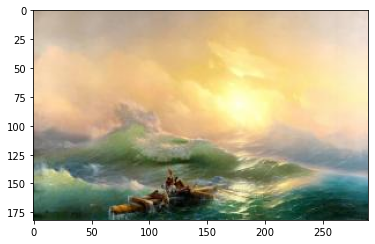

In [35]:
# Load image
image_path = ".\\Art_dataset\\dataset\\training_set\\painting\\1528.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

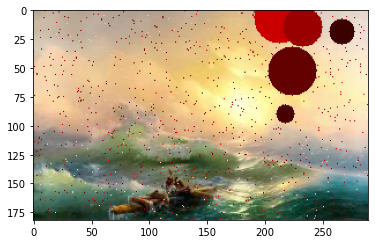

In [36]:
# Simulate damage on the image
import random

noisy_image = add_random_red_noise(image)
noisy_image = add_salt_and_pepper_red_noise(noisy_image)
noisy_image = add_large_red_spots(noisy_image)
plt.imshow(noisy_image)
plt.show()

## Restore the image

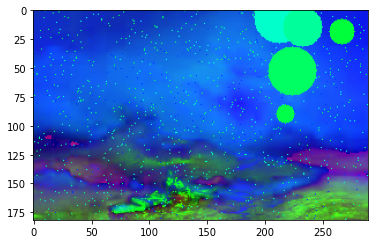

In [37]:
hsv = cv2.cvtColor(noisy_image, cv2.COLOR_RGB2HSV)
plt.imshow(hsv)
plt.show()

If, for instance, damages are primarily of a certain color (like reddish stains), we can create masks that capture those regions. For this demonstration, let's assume we want to capture reddish hues:

In [44]:
# Create a mask for reddish hues
lower_red1 = np.array([0, 50, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 50, 50])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

You can combine the color-based mask with the masks obtained from grayscale processing (like adaptive thresholding) to further refine the regions of interest.

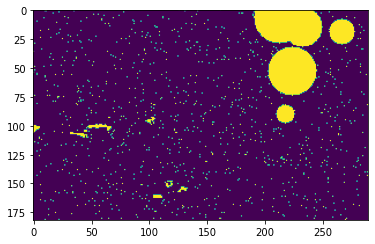

In [45]:
red_mask = mask1 + mask2
plt.imshow(red_mask)
plt.show()                             

Remove salt&pepper noise - apply Median Filter 5 x 5

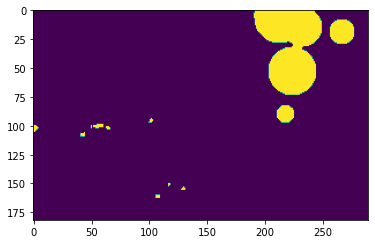

In [48]:
diameter = TODO
filtered_red_mask = cv2.medianBlur(red_mask, diameter) 
plt.imshow(filtered_red_mask)
plt.show() 
#

Apply morphological operations, kernel size 7 x 7

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

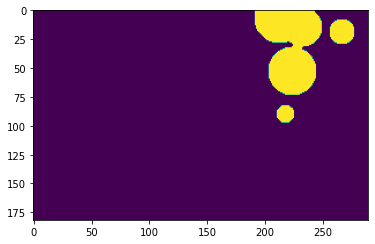

In [50]:
diameter = TODO
kernel = np.ones((diameter, diameter),np.uint8)
opening = cv2.morphologyEx(filtered_red_mask, cv2.MORPH_OPEN, kernel) # dilacija erozije - zgodno za uklanjanje manjeg šuma (struktura koje su svetlije od okruženja)
plt.imshow(opening)
plt.show() 

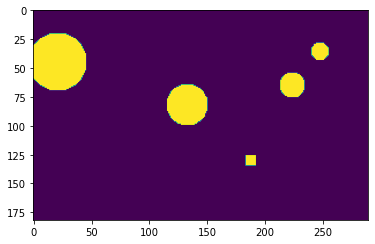

In [11]:
# Adaptive Thresholding
#binary_mask = cv2.adaptiveThreshold(opening, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
_, binary_mask = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary_mask)
plt.show() 

6


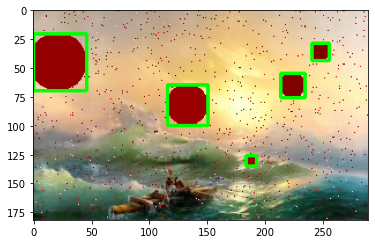

In [12]:
# Find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

print(num_labels)

# Create a result image
result = noisy_image.copy()
for i in range(1, num_labels):
    # Draw a bounding box around the connected component
    x, y, w, h, area = stats[i]
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(result)
plt.show()

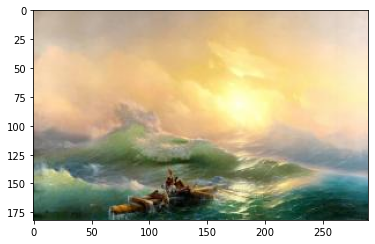

In [13]:
# Restore the image by masking the detected defects
# Restore the image by replacing the detected defects with the original pixels
restored_image = np.copy(noisy_image)
for i in range(1, num_labels):
    mask = (labels == i)
    restored_image[mask] = image[mask]
        
restored_image = np.clip(restored_image, 0, 255).astype(np.uint8)

# Display or save results (optional)
plt.imshow(image)

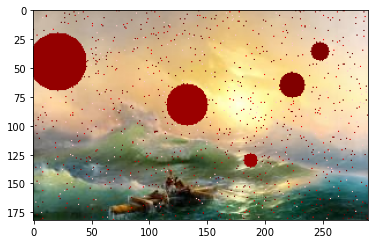

In [14]:
plt.imshow(noisy_image)

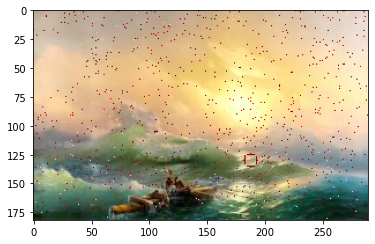

In [15]:
plt.imshow(restored_image)

Median blur to remove salt&pepper noise (use diameter 3)

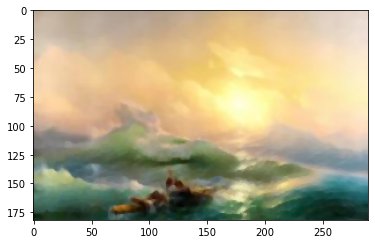

In [52]:
diameter = TODO
restored_image = cv2.medianBlur(restored_image, diameter)
plt.imshow(restored_image)

## Automatic measurement of success

A simple way to measure the success of the restoration algorithm is to compute the Mean Squared Error (MSE) between the processed image and the original (undamaged) image. A lower MSE indicates that the processed image is closer to the original image.

In [21]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# Assuming `result` is the image after processing
error = mse(restored_image, image)
print(f"MSE between processed and original image: {error}")

MSE between processed and original image: 61.025085259568016


Another metric is the Structural Similarity Index (SSIM), which considers changes in structural information, luminance, and texture. Higher SSIM values (closer to 1) indicate greater similarity.

While MSE gives a sense of pixel-level differences, SSIM provides a more perceptual measure of similarity. Both can be used in conjunction to gauge the effectiveness of the restoration.

In [25]:
#!pip install scikit-image --user 
#!pip uninstall pdpbox

In [24]:
from skimage.metrics import structural_similarity as compare_ssim

# Convert the images to grayscale since SSIM comparison requires single channel images
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
restored_gray = cv2.cvtColor(restored_image, cv2.COLOR_RGB2GRAY)

# Compute SSIM between two images
ssim_value = compare_ssim(image_gray, restored_gray)

print(f"SSIM: {ssim_value}")

SSIM: 0.9690842311996364


Error Analysis:
1. **False Positives and Negatives**: By comparing the regions identified as damaged with a reference (or by manual inspection), students can gauge how many false positives (incorrectly identified regions) or false negatives (missed damaged regions) the algorithm produces.

2. **Optimal Thresholding**: Different images might require different thresholding techniques or parameters. The chosen thresholding method's appropriateness can be evaluated by checking the segmented regions' relevance to the problem context.

3. **Morphological Operations**: Over-erosion or over-dilation can either erase relevant information or introduce unnecessary noise. By assessing the post-morphological-operation image against the original, students can determine if the operations are too aggressive or too mild.

4. **Connected Component Analysis**: If smaller damaged regions are close together, they might be detected as a single large region. Fine-tuning morphological operations or connected component parameters can help.

5. **Generalization to Different Artworks**: The effectiveness of the chosen approach on a diverse set of images can highlight biases or overfitting to specific types of images.

To improve results, students can experiment with different techniques or parameter settings mentioned in the lecture, integrate additional image processing methods, or even apply machine learning algorithms for more advanced tasks.